# Create a hexagon grid covering Toronto

This example shows how to use the `accessto.point.build_haxagonal_grid` function to build a hexagonal grid covering Toronto,
is trimmed at the boundaries to follow Toronto's boundaries. 

The steps used in this example are as follows:
1. Create the hexagonal grid
2. Do a spatial join to only keep polygons that at least touch the City area
3. Trim polygons to follow the boundary borders.
4. Find the representative point for the polygons, which is what we'll use for the accessibilities 

The polygon and centroids are saved to a shapefile for future analyses.

In [ ]:
import geopandas as gpd
from pathlib import Path
from shapely import Point

from accessto.points import build_haxagonal_grid

## Input files

In [ ]:
root_dir = Path(r"C:\Access To Opportunities")
data_root_dir = root_dir / "Data"

# City of Toronto boundary file, as downloaded from City of Toronto Open Data
tor_bndry_fp = data_root_dir / "StatisticsCanada" / "Toronto_boundaries.shp"

# Create a working directory to hold files
working_dir = root_dir / "working"
working_dir.mkdir(exist_ok=True)

wgs84_proj_str = "EPSG:4326"
cot_proj_str = "EPSG:2952"

### Create the hexagonal grid

In [ ]:
# In this example we will be trimming some of the hexagons to follow Toronto's borders. As the geometry
# will change for these cells, we'll need to recompute the centroids later, hence in this case we can
# ignore the centroids output from `build_hexagonal_grid`.
_, hex_polgns = build_haxagonal_grid(
    lower_left=Point(-79.580, 43.54),    # This is suitable lower-left point for a rectangle boundary that will cover Toronto
    incr=500,                            # 500 m spacing of the hexagonal grid
    width=44000,                         # 44 km in width
    height=24000,                        # 24 km in height
    angle=18.2                           # I've found that this angle really matches the east-west roads.
)
# Project to the City's preferred projection system
hex_polgns = hex_polgns.to_crs(cot_proj_str)
hex_polgns.to_file(working_dir / "hex_polgns_1.shp")

This is the image of the hexagon grid after this step.

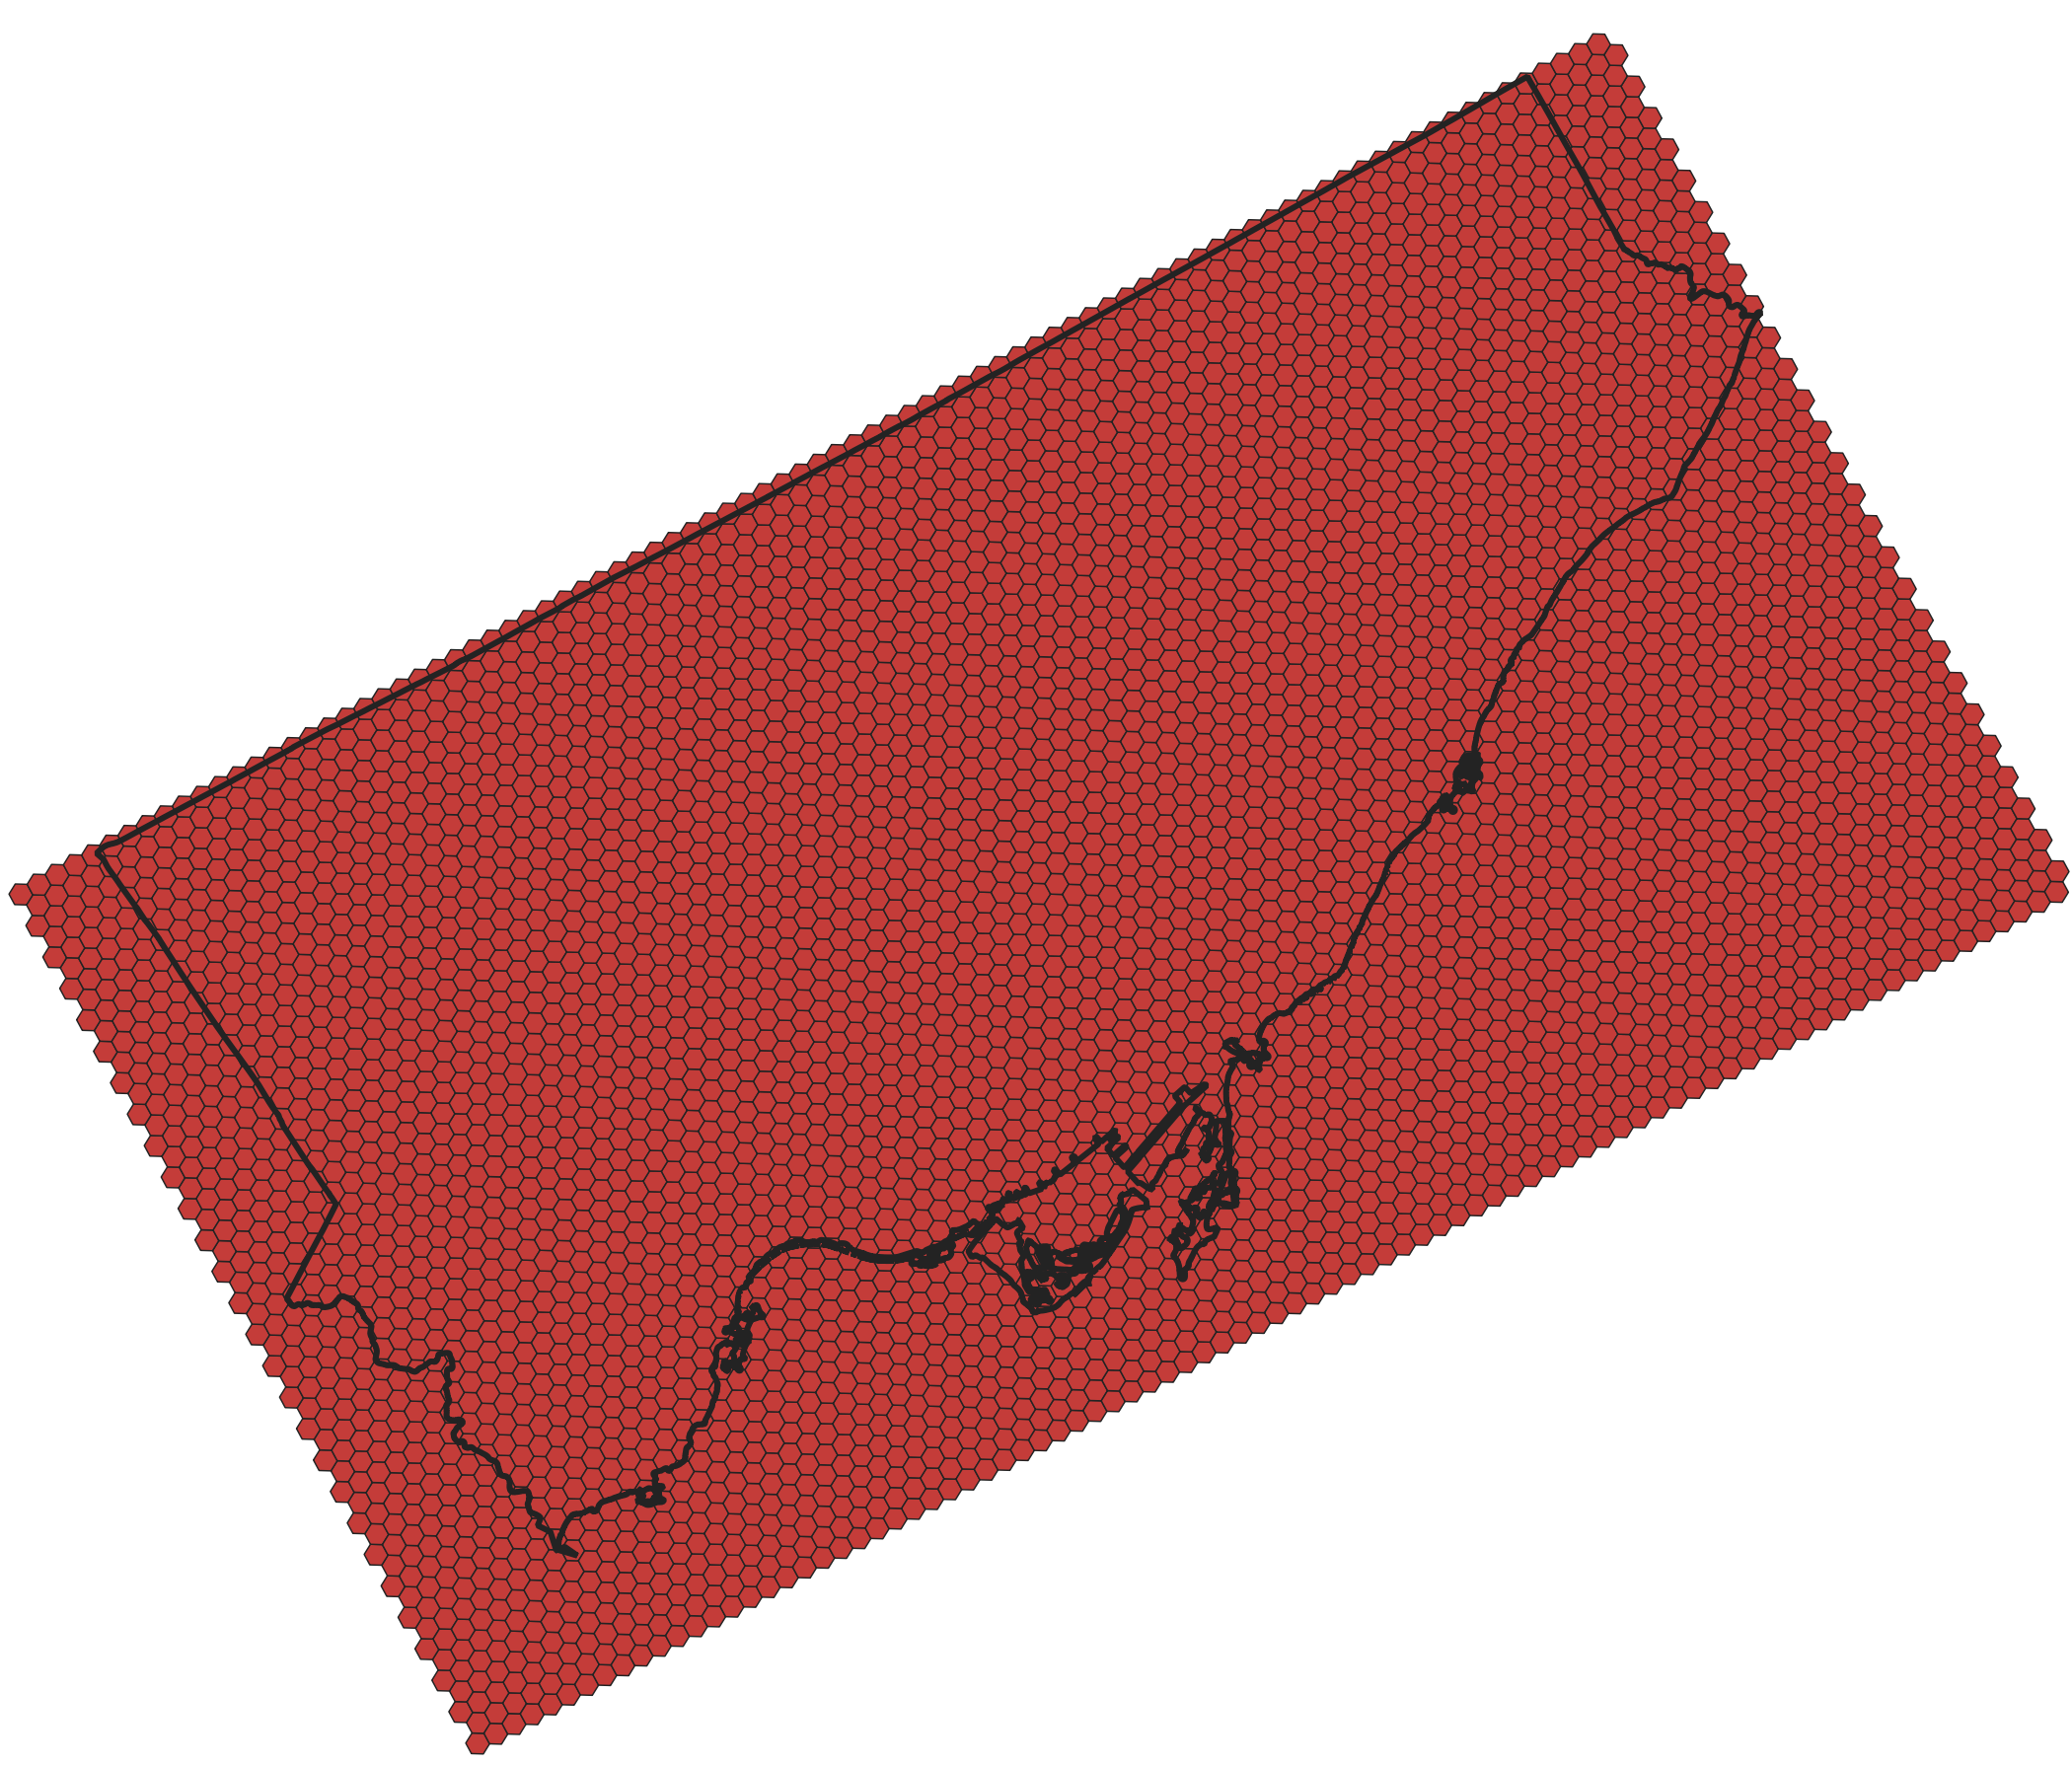

### Trim to City of Toronto Municipal Boundary

- Look for centroids that are within the boundary
- Keep those polygons only

In [ ]:
# Read in the Toronto Boundary File to a geopandas GeoDataFrame, and project to the 
# City's preferred coordinate system.
toronto_bndry_gdf = gpd.GeoDataFrame.from_file(tor_bndry_fp)
toronto_bndry_gdf = toronto_bndry_gdf.to_crs(cot_proj_str)
toronto_bndry_gdf = toronto_bndry_gdf[['geometry']]

In [ ]:
# Perform a spatial join to keep polygons that touch the boundary polygon file.
# Then clip the polygons to follow the city's borders.
hex_polgns2 = gpd.sjoin(hex_polgns, toronto_bndry_gdf, how="inner")
hex_polgns2 = hex_polgns2.drop(['index_right'], axis=1)
hex_polgns2 = gpd.clip(hex_polgns2, toronto_bndry_gdf)

In [ ]:
# Now get the representative point of this polygon, this will be the point locations
# for each cell that we use in the travel time computations.
hex_pts = hex_polgns2.copy()

hex_pts['repr_pt'] = hex_pts.representative_point()
hex_pts = hex_pts.set_geometry('repr_pt')
hex_pts = hex_pts.drop(['geometry'], axis=1)

In [ ]:
# We're done, export the polygons and points shapefile
hex_polgns2.to_file(working_dir / "hex_polgns_final.shp", index=False)
hex_pts.to_file(working_dir / "hex_pts_final.shp", index=False)

Here's the final hexagonal mesh.

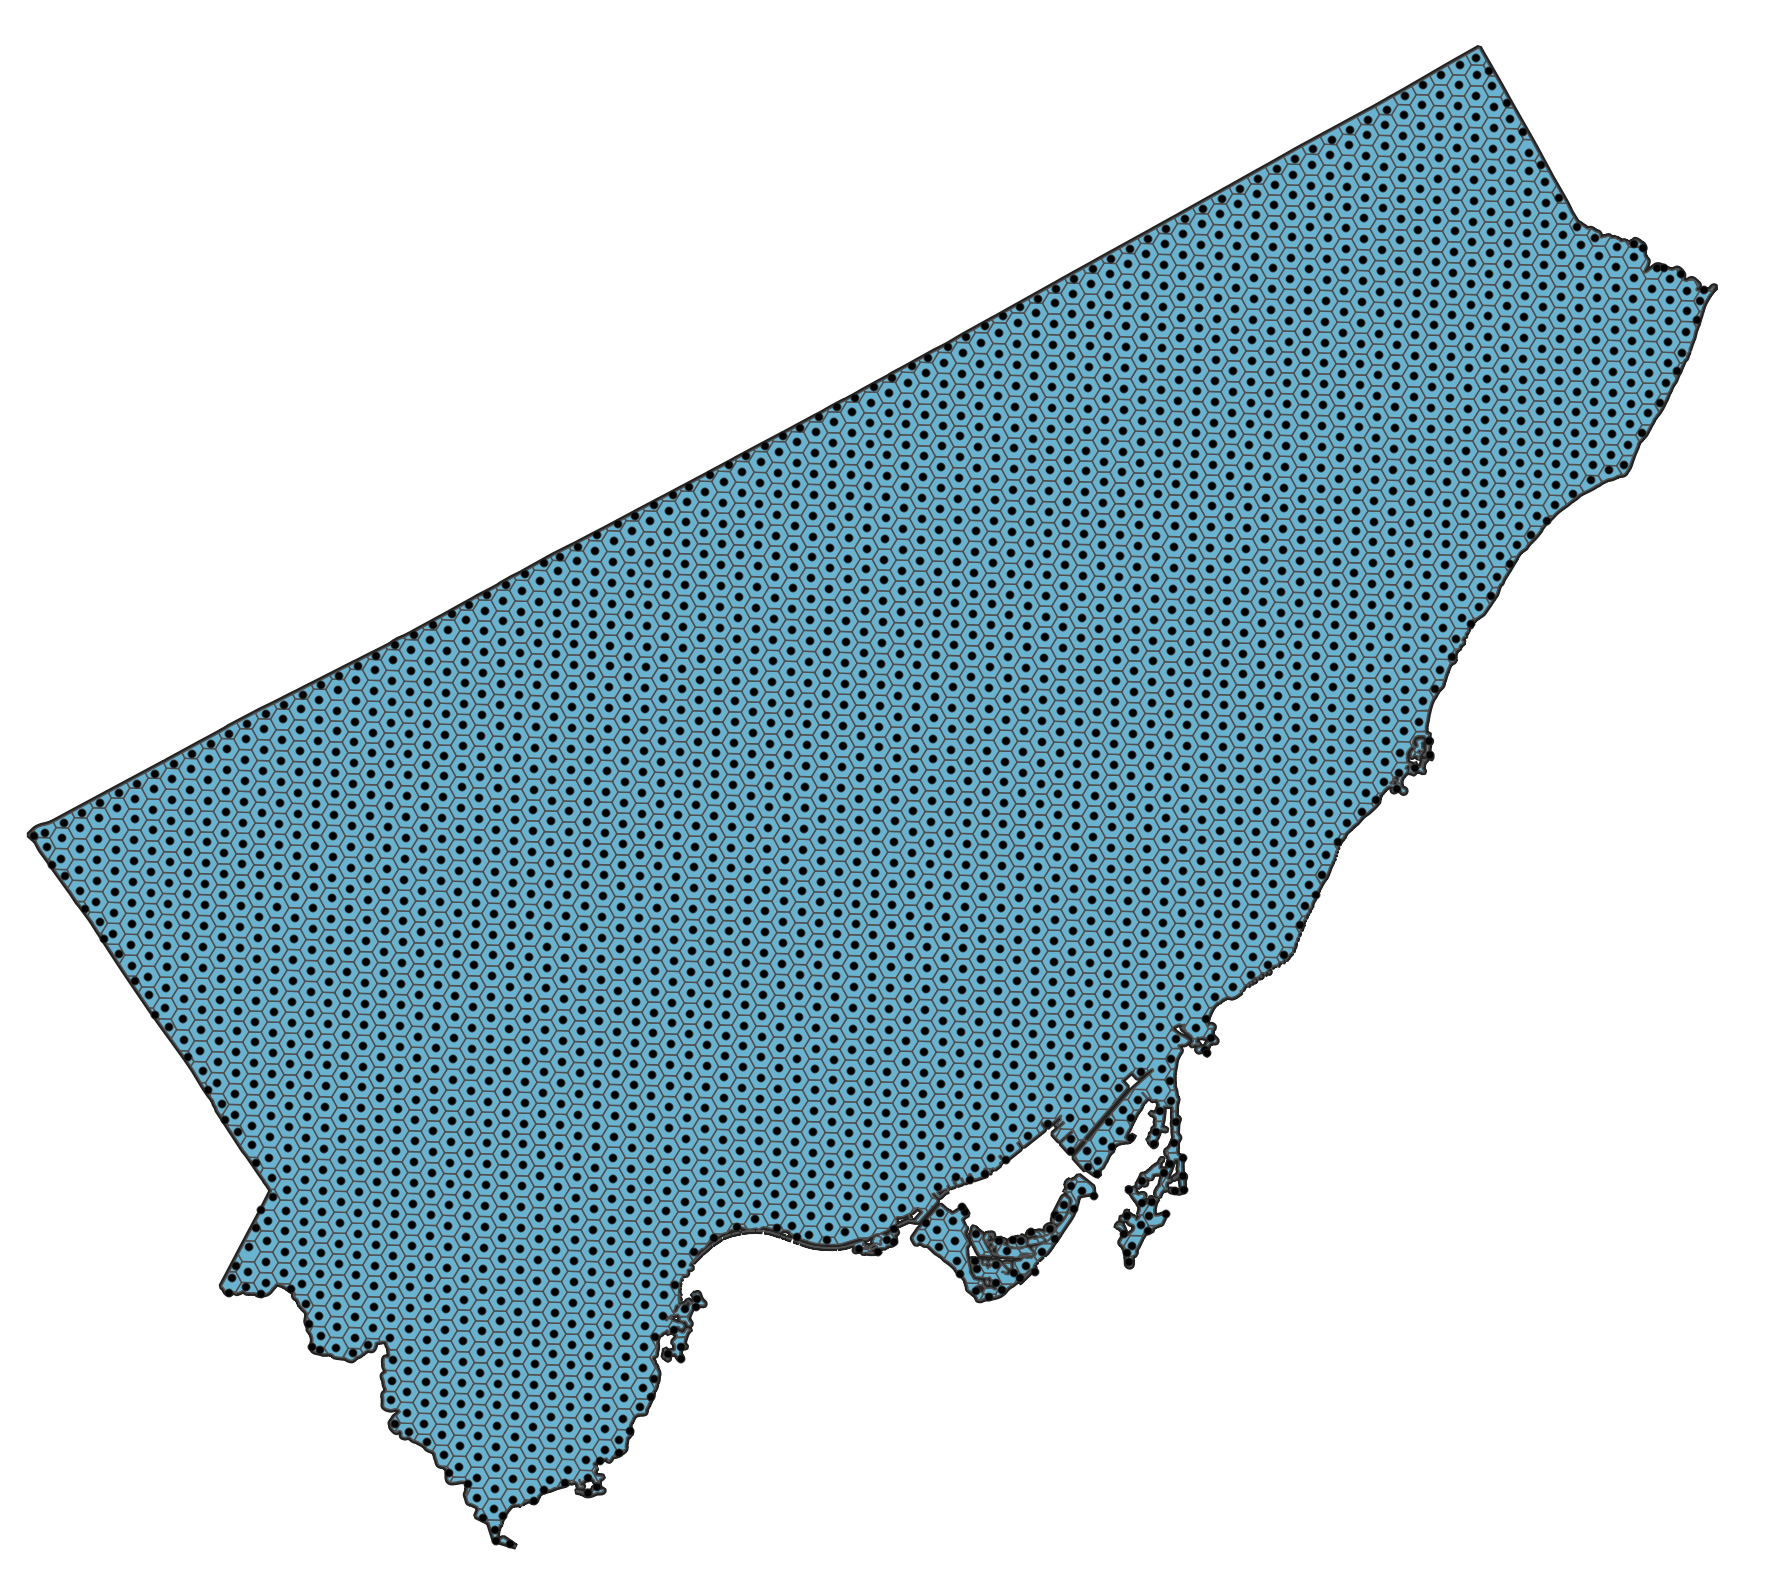